In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pandas as pd

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [3]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.87MB/s]


In [4]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:

class CNN(nn.Module):
    def __init__(self, conv_channels=[16, 32], fc_neurons=128, activation='relu', num_classes=10):
        super(CNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        in_channels = 1

        for out_channels in conv_channels:
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            in_channels = out_channels

        self.pool = nn.MaxPool2d(2, 2)

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'leakyrelu':
            self.activation = F.leaky_relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        else:
            raise ValueError("Unsupported activation function")

        self._initialize_fc(fc_neurons, num_classes)

    def _initialize_fc(self, fc_neurons, num_classes):
        x = torch.zeros(1, 1, 28, 28)
        with torch.no_grad():
            for conv in self.conv_layers:
                x = self.activation(conv(x))
                x = self.pool(x)
        flatten_dim = x.numel()
        self.fc1 = nn.Linear(flatten_dim, fc_neurons)
        self.fc2 = nn.Linear(fc_neurons, num_classes)
        self.flatten_dim = flatten_dim
    def forward(self, x):
        for conv in self.conv_layers:
            x = self.activation(conv(x))
            x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x



In [5]:
model_configs = [
    {"name": "relu_32_64", "conv_channels": [32, 64], "fc_neurons": 128,
     "activation": "relu", "lr": 0.001, "epochs": 3},
    {"name": "leakyrelu_32_64", "conv_channels": [32, 64], "fc_neurons": 128,
     "activation": "leakyrelu", "lr": 0.001, "epochs": 3},
    {"name": "tanh_32_64", "conv_channels": [32, 64], "fc_neurons": 128,
     "activation": "tanh", "lr": 0.001, "epochs": 3},

    {"name": "relu_16_32", "conv_channels": [16, 32], "fc_neurons": 128,
     "activation": "relu", "lr": 0.001, "epochs": 3},
    {"name": "relu_32_64_filters", "conv_channels": [32, 64], "fc_neurons": 128,
     "activation": "relu", "lr": 0.001, "epochs": 3},

    {"name": "relu_8_16_32", "conv_channels": [8, 16, 32], "fc_neurons": 128,
     "activation": "relu", "lr": 0.001, "epochs": 3},
    {"name": "relu_16_32_layers", "conv_channels": [16, 32], "fc_neurons": 128,
     "activation": "relu", "lr": 0.001, "epochs": 3},

    {"name": "relu_32_64_lr0005", "conv_channels": [32, 64], "fc_neurons": 128,
     "activation": "relu", "lr": 0.0005, "epochs": 3},
    {"name": "relu_32_64_lr001", "conv_channels": [32, 64], "fc_neurons": 128,
     "activation": "relu", "lr": 0.001, "epochs": 3},

    {"name": "relu_32_64_3epochs", "conv_channels": [32, 64], "fc_neurons": 128,
     "activation": "relu", "lr": 0.001, "epochs": 3},
    {"name": "relu_32_64_5epochs", "conv_channels": [32, 64], "fc_neurons": 128,
     "activation": "relu", "lr": 0.001, "epochs": 5},

    {"name": "deep_relu_8_16_32_64_fc256_lr0005_10epochs",
     "conv_channels": [8, 16, 32, 64], "fc_neurons": 256,
     "activation": "relu", "lr": 0.0005, "epochs": 10},

    {"name": "shallow_tanh_16_32_fc64_lr005_3epochs",
     "conv_channels": [16, 32], "fc_neurons": 64,
     "activation": "tanh", "lr": 0.005, "epochs": 3},

    {"name": "mid_leakyrelu_32_64_128_fc128_lr001_5epochs",
     "conv_channels": [32, 64, 128], "fc_neurons": 128,
     "activation": "leakyrelu", "lr": 0.001, "epochs": 5},
]


In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=3, name="model"):
    model.to(device)
    print(f"Training {name}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        end_time = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss: {running_loss/len(train_loader):.4f}, "
              f"Accuracy: {100*correct/total:.2f}%, "
              f"Time: {end_time-start_time:.2f}s")


In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total



In [ ]:

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

for config in model_configs:
    model = CNN(conv_channels=config["conv_channels"],
                fc_neurons=config["fc_neurons"],
                activation=config["activation"])

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    start_time = time.time()
    train_model(model, train_loader, criterion, optimizer, device, num_epochs=config["epochs"], name=config["name"])
    training_time = time.time() - start_time

    test_acc = test_model(model, test_loader, device)

    results.append({
        "Model": config["name"],
        "Conv Channels": config["conv_channels"],
        "Activation": config["activation"],
        "Learning Rate": config["lr"],
        "Epochs": config["epochs"],
        "Training Time (s)": training_time,
        "Test Accuracy (%)": test_acc
    })



Training relu_32_64
Epoch [1/3], Loss: 0.1495, Accuracy: 95.51%, Time: 82.11s
Epoch [2/3], Loss: 0.0447, Accuracy: 98.61%, Time: 83.58s
Epoch [3/3], Loss: 0.0301, Accuracy: 99.03%, Time: 83.82s
Training leakyrelu_32_64
Epoch [1/3], Loss: 0.1426, Accuracy: 95.67%, Time: 85.38s
Epoch [2/3], Loss: 0.0411, Accuracy: 98.72%, Time: 82.12s
Epoch [3/3], Loss: 0.0268, Accuracy: 99.14%, Time: 81.66s
Training tanh_32_64
Epoch [1/3], Loss: 0.1530, Accuracy: 95.57%, Time: 88.13s
Epoch [2/3], Loss: 0.0473, Accuracy: 98.56%, Time: 91.44s
Epoch [3/3], Loss: 0.0320, Accuracy: 99.05%, Time: 88.29s
Training relu_16_32
Epoch [1/3], Loss: 0.1928, Accuracy: 94.24%, Time: 42.85s
Epoch [2/3], Loss: 0.0505, Accuracy: 98.46%, Time: 43.26s
Epoch [3/3], Loss: 0.0358, Accuracy: 98.91%, Time: 43.64s
Training relu_32_64_filters
Epoch [1/3], Loss: 0.1585, Accuracy: 95.20%, Time: 80.11s
Epoch [2/3], Loss: 0.0465, Accuracy: 98.57%, Time: 80.92s
Epoch [3/3], Loss: 0.0324, Accuracy: 99.00%, Time: 81.45s
Training relu_8_1

In [ ]:
df_results = pd.DataFrame(results)
print(df_results)


                                          Model    Conv Channels Activation  \
0                                    relu_32_64         [32, 64]       relu   
1                               leakyrelu_32_64         [32, 64]  leakyrelu   
2                                    tanh_32_64         [32, 64]       tanh   
3                                    relu_16_32         [16, 32]       relu   
4                            relu_32_64_filters         [32, 64]       relu   
5                                  relu_8_16_32      [8, 16, 32]       relu   
6                             relu_16_32_layers         [16, 32]       relu   
7                             relu_32_64_lr0005         [32, 64]       relu   
8                              relu_32_64_lr001         [32, 64]       relu   
9                            relu_32_64_3epochs         [32, 64]       relu   
10                           relu_32_64_5epochs         [32, 64]       relu   
11   deep_relu_8_16_32_64_fc256_lr0005_10epochs  [8,

In [ ]:
df_results

,Model,Conv Channels,Activation,Learning Rate,Epochs,Training Time (s),Test Accuracy (%)
0,relu_32_64,"[32, 64]",relu,0.0010,3,249.511456,99.02
1,leakyrelu_32_64,"[32, 64]",leakyrelu,0.0010,3,249.162272,98.78
2,tanh_32_64,"[32, 64]",tanh,0.0010,3,267.871112,98.79
3,relu_16_32,"[16, 32]",relu,0.0010,3,129.745852,98.76
4,relu_32_64_filters,"[32, 64]",relu,0.0010,3,242.476469,98.88
5,relu_8_16_32,"[8, 16, 32]",relu,0.0010,3,93.895716,98.40
6,relu_16_32_layers,"[16, 32]",relu,0.0010,3,127.498697,98.50
7,relu_32_64_lr0005,"[32, 64]",relu,0.0005,3,256.745902,98.75
8,relu_32_64_lr001,"[32, 64]",relu,0.0010,3,242.612757,98.77
9,relu_32_64_3epochs,"[32, 64]",relu,0.0010,3,247.872037,98.98


In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self, conv_channels=[16, 32], activation='relu'):
        super(ConvAutoencoder, self).__init__()

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'leakyrelu':
            self.activation = F.leaky_relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        else:
            raise ValueError("Unsupported activation")

        encoder_layers = []
        in_channels = 1
        for out_channels in conv_channels:
            encoder_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1))
            encoder_layers.append(nn.BatchNorm2d(out_channels))
            encoder_layers.append(nn.ReLU())
            in_channels = out_channels
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = []
        for i in range(len(conv_channels) - 1, 0, -1):
            decoder_layers.append(nn.ConvTranspose2d(conv_channels[i], conv_channels[i - 1], kernel_size=3, stride=2, padding=1, output_padding=1))
            decoder_layers.append(nn.BatchNorm2d(conv_channels[i - 1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.ConvTranspose2d(conv_channels[0], 1, kernel_size=3, stride=2, padding=1, output_padding=1))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      x = x[:, :, :28, :28]
      return x


In [7]:
def train_autoencoder(model, train_loader, criterion, optimizer, device, num_epochs=5, name="autoencoder"):
    model.to(device)
    print(f"\nTraining {name}")
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in {total_time:.2f} seconds")
    return total_time


In [8]:
def test_autoencoder(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f"Reconstruction Error (MSE): {avg_loss:.6f}")
    return avg_loss


In [9]:
def visualize_reconstruction(model, test_loader, device, n=10):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            break
    images = images.cpu()
    outputs = outputs.cpu()

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        plt.subplot(2, n, n + i + 1)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")
    plt.show()



Training relu_32_64
Epoch [1/3], Loss: 0.870208
Epoch [2/3], Loss: 0.834141
Epoch [3/3], Loss: 0.833510
Training completed in 41.19 seconds
Reconstruction Error (MSE): 0.831571


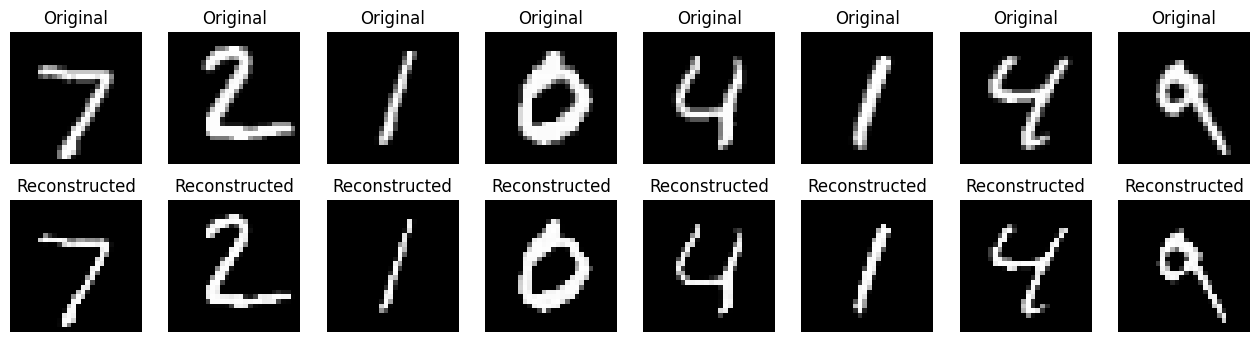


Training leakyrelu_32_64
Epoch [1/3], Loss: 0.886733
Epoch [2/3], Loss: 0.834261
Epoch [3/3], Loss: 0.833510
Training completed in 40.68 seconds
Reconstruction Error (MSE): 0.831555


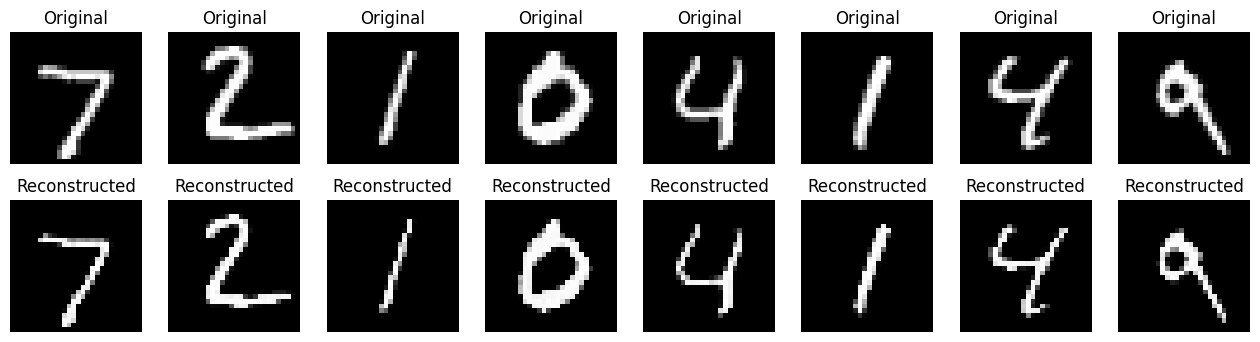


Training tanh_32_64
Epoch [1/3], Loss: 0.875358
Epoch [2/3], Loss: 0.834191
Epoch [3/3], Loss: 0.833497
Training completed in 40.48 seconds
Reconstruction Error (MSE): 0.831573


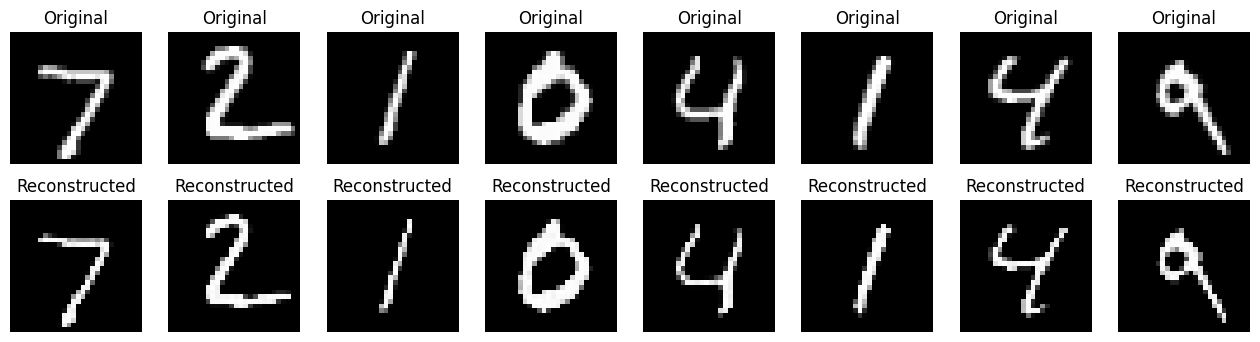


Training relu_16_32
Epoch [1/3], Loss: 0.919659
Epoch [2/3], Loss: 0.836019
Epoch [3/3], Loss: 0.834176
Training completed in 40.08 seconds
Reconstruction Error (MSE): 0.832027


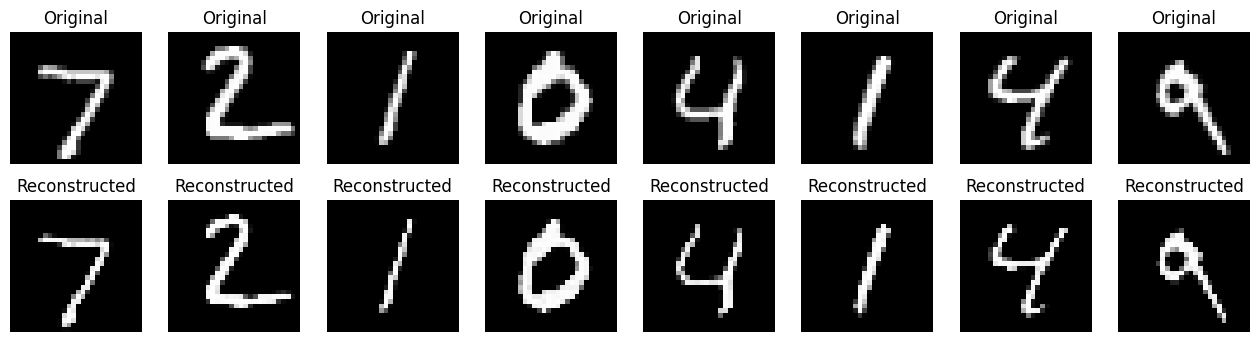


Training relu_32_64_filters
Epoch [1/3], Loss: 0.886595
Epoch [2/3], Loss: 0.834281
Epoch [3/3], Loss: 0.833561
Training completed in 40.47 seconds
Reconstruction Error (MSE): 0.831637


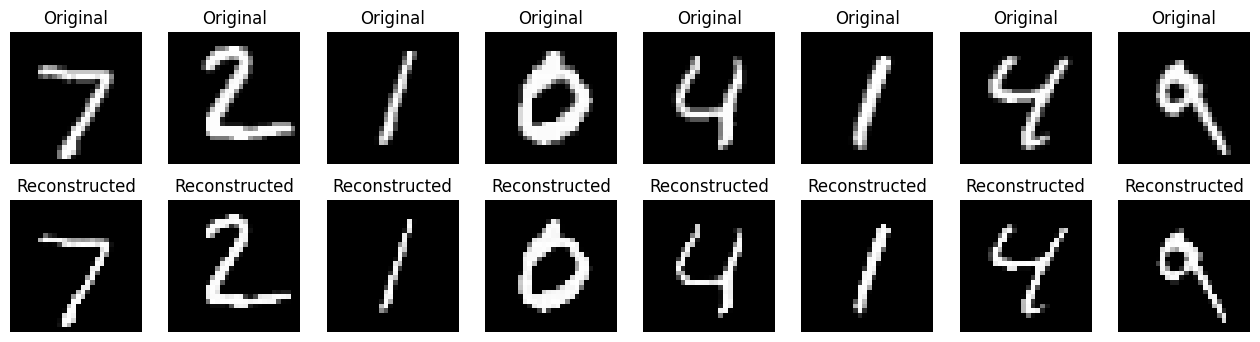


Training relu_8_16_32
Epoch [1/3], Loss: 1.022324
Epoch [2/3], Loss: 0.844960
Epoch [3/3], Loss: 0.838920
Training completed in 42.00 seconds
Reconstruction Error (MSE): 0.835685


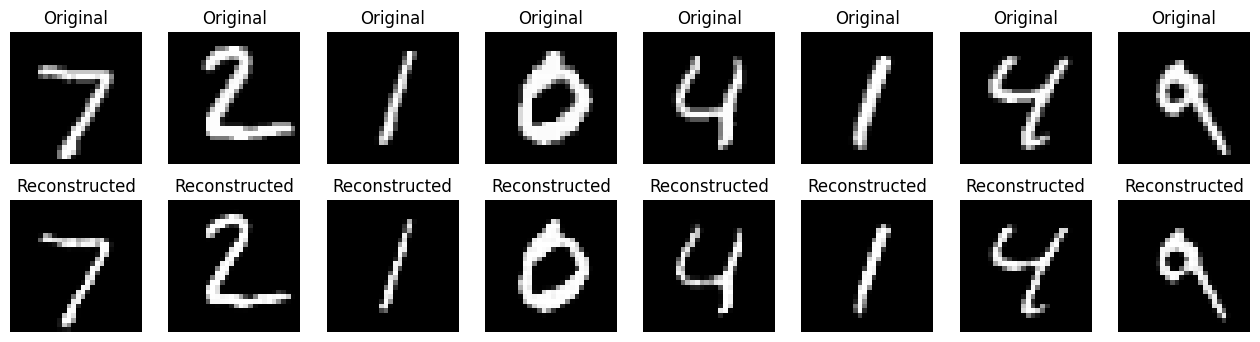


Training relu_16_32_layers
Epoch [1/3], Loss: 0.927564
Epoch [2/3], Loss: 0.836305
Epoch [3/3], Loss: 0.834273
Training completed in 40.00 seconds
Reconstruction Error (MSE): 0.832081


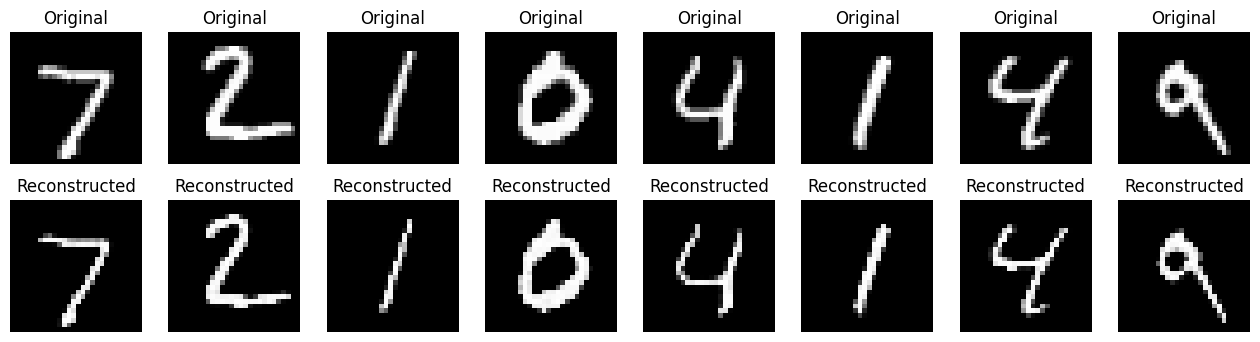


Training relu_32_64_lr0005
Epoch [1/3], Loss: 0.906990
Epoch [2/3], Loss: 0.836448
Epoch [3/3], Loss: 0.834179
Training completed in 39.91 seconds
Reconstruction Error (MSE): 0.832052


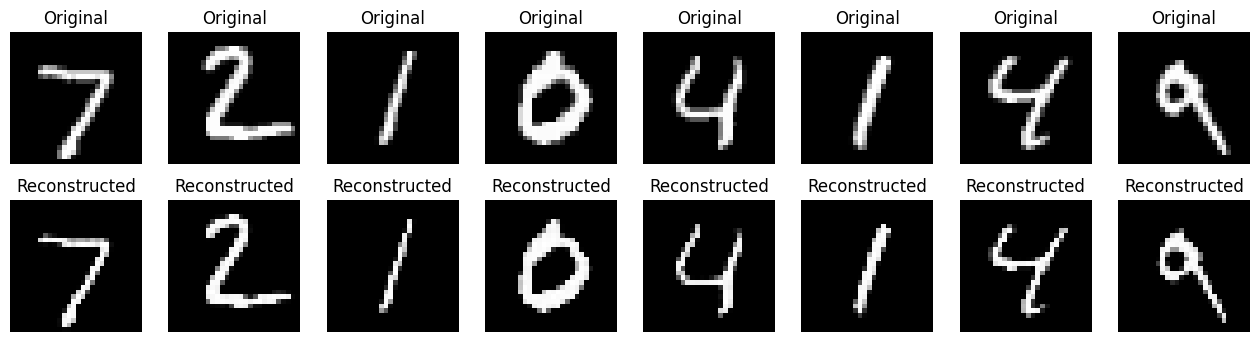


Training relu_32_64_lr001
Epoch [1/3], Loss: 0.871300
Epoch [2/3], Loss: 0.834010
Epoch [3/3], Loss: 0.833478
Training completed in 39.80 seconds
Reconstruction Error (MSE): 0.831525


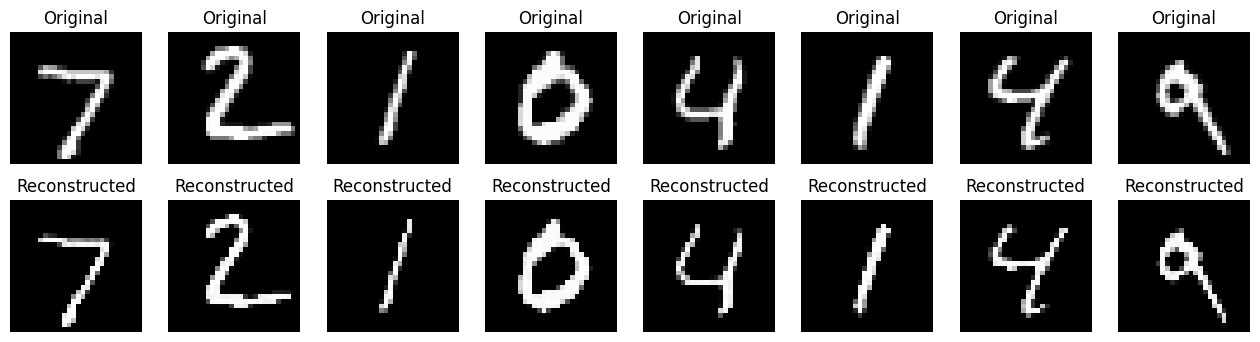


Training relu_32_64_3epochs
Epoch [1/3], Loss: 0.870233
Epoch [2/3], Loss: 0.834053
Epoch [3/3], Loss: 0.833479
Training completed in 40.27 seconds
Reconstruction Error (MSE): 0.831529


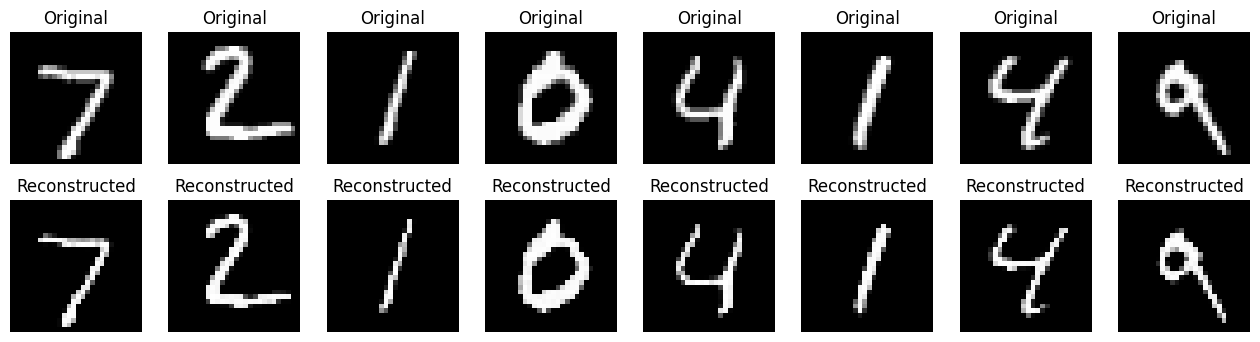


Training relu_32_64_5epochs
Epoch [1/5], Loss: 0.878489
Epoch [2/5], Loss: 0.834291
Epoch [3/5], Loss: 0.833563
Epoch [4/5], Loss: 0.833362
Epoch [5/5], Loss: 0.833258
Training completed in 66.34 seconds
Reconstruction Error (MSE): 0.831410


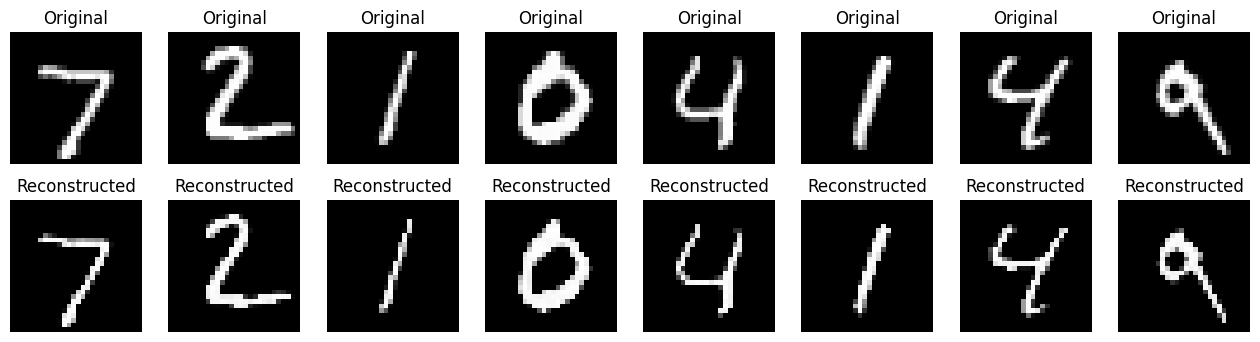


Training deep_relu_8_16_32_64_fc256_lr0005_10epochs
Epoch [1/10], Loss: 1.089195
Epoch [2/10], Loss: 0.870881
Epoch [3/10], Loss: 0.853137
Epoch [4/10], Loss: 0.847310
Epoch [5/10], Loss: 0.844492
Epoch [6/10], Loss: 0.842658
Epoch [7/10], Loss: 0.841457
Epoch [8/10], Loss: 0.840677
Epoch [9/10], Loss: 0.840040
Epoch [10/10], Loss: 0.839603
Training completed in 147.76 seconds
Reconstruction Error (MSE): 0.837218


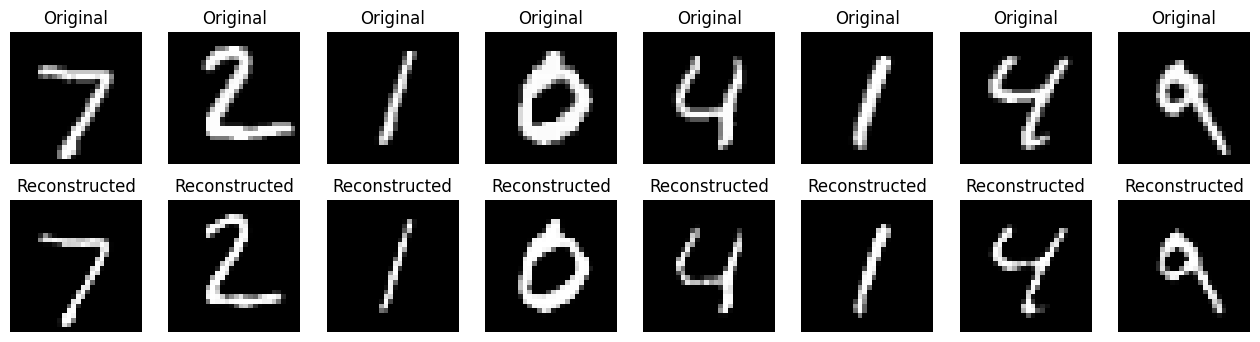


Training shallow_tanh_16_32_fc64_lr005_3epochs
Epoch [1/3], Loss: 0.857601
Epoch [2/3], Loss: 0.833743
Epoch [3/3], Loss: 0.833476
Training completed in 39.57 seconds
Reconstruction Error (MSE): 0.831727


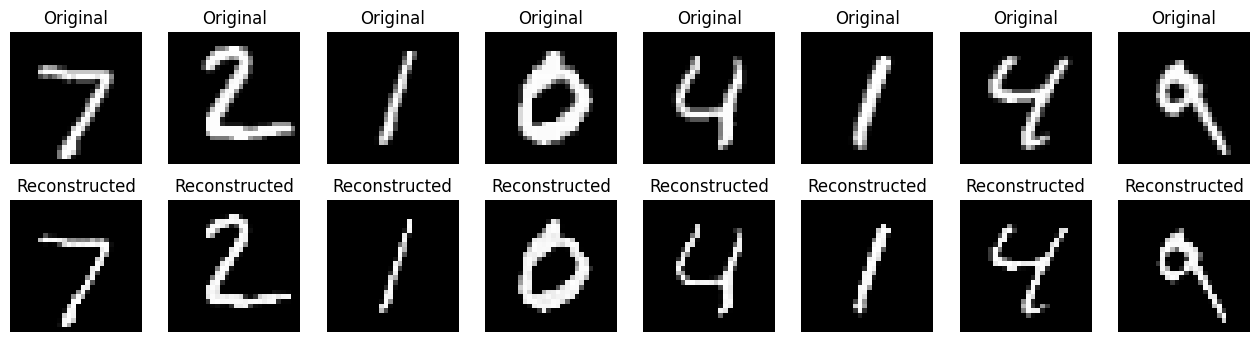


Training mid_leakyrelu_32_64_128_fc128_lr001_5epochs
Epoch [1/5], Loss: 0.864917
Epoch [2/5], Loss: 0.834917
Epoch [3/5], Loss: 0.834110
Epoch [4/5], Loss: 0.833805
Epoch [5/5], Loss: 0.833639
Training completed in 76.64 seconds
Reconstruction Error (MSE): 0.831990


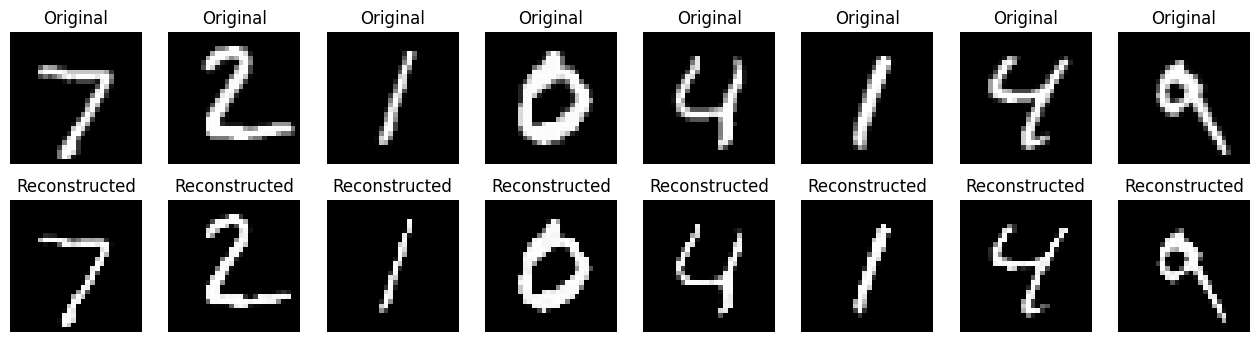

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results_ae = []

for config in model_configs:
    model = ConvAutoencoder(conv_channels=config["conv_channels"], activation=config["activation"]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    train_time = train_autoencoder(model, train_loader, criterion, optimizer, device,
                                   num_epochs=config["epochs"], name=config["name"])
    reconstruction_error = test_autoencoder(model, test_loader, criterion, device)

    results_ae.append({
        "Model": config["name"],
        "Conv Channels": config["conv_channels"],
        "Activation": config["activation"],
        "Learning Rate": config["lr"],
        "Epochs": config["epochs"],
        "Training Time (s)": train_time,
        "Reconstruction Error (MSE)": reconstruction_error
    })

    visualize_reconstruction(model, test_loader, device, n=8)


In [12]:
df_results = pd.DataFrame(results_ae)
df_results


,Model,Conv Channels,Activation,Learning Rate,Epochs,Training Time (s),Reconstruction Error (MSE)
0,relu_32_64,"[32, 64]",relu,0.0010,3,41.188738,0.831571
1,leakyrelu_32_64,"[32, 64]",leakyrelu,0.0010,3,40.677584,0.831555
2,tanh_32_64,"[32, 64]",tanh,0.0010,3,40.476050,0.831573
3,relu_16_32,"[16, 32]",relu,0.0010,3,40.077290,0.832027
4,relu_32_64_filters,"[32, 64]",relu,0.0010,3,40.473738,0.831637
5,relu_8_16_32,"[8, 16, 32]",relu,0.0010,3,41.995959,0.835685
6,relu_16_32_layers,"[16, 32]",relu,0.0010,3,40.004548,0.832081
7,relu_32_64_lr0005,"[32, 64]",relu,0.0005,3,39.906731,0.832052
8,relu_32_64_lr001,"[32, 64]",relu,0.0010,3,39.797204,0.831525
9,relu_32_64_3epochs,"[32, 64]",relu,0.0010,3,40.274165,0.831529
